In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import os
from sklearn.neighbors import DistanceMetric
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, silhouette_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from warnings import filterwarnings
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
from IPython.display import display
from datetime import datetime

filterwarnings('ignore')

# Data

---
- flag_2 : inspections which yielded 2 or more critical violations
- flag_3: inspections which yielded 3 or more critical violations


In [9]:
path = 'C:/Users/adley/Google Drive/School/Capstone/data'
os.chdir(path)

bizcols = ['camis', 'dba', 'boro', 'zipcode', 'address', 'cuisine', 'url', 'price', 'rating', 'lat', 'lon']

biz = pd.read_csv('biz.csv', usecols = bizcols, dtype={'camis': int, 'zipcode':str})
senti = pd.read_csv('yelp_sentiments.csv', dtype={'camis': int})
flagwords = pd.read_csv('flagwords.csv', dtype={'camis':int})
chain = pd.read_csv('violations.csv', usecols = ['camis', 'chain'], dtype={'camis':int})


vio = pd.read_csv('archive/newvio.csv', dtype={'camis': int}, parse_dates = ['inspection_date']) \
        .sort_values(['camis', 'inspection_date']) \
        .reset_index(drop = True)

vio['next_inspection_date'] = vio.groupby('camis')['inspection_date'].shift(-1)

mostRecent = vio[vio.next_inspection_date.isna()] \
                .drop('next_inspection_date', axis = 1) \
                .merge(pd.get_dummies(biz[['camis', 'cuisine', 'price', 'rating']]), how = 'left', on = 'camis').dropna() \
                .merge(chain, how = 'left', on = 'camis') \
                .merge(flagwords, how = 'left', on = 'camis') \
                .merge(senti, how = 'left', on = 'camis') \
                .fillna(0)

x2 = mostRecent.loc[:, '02A':]
x2['camis'] = mostRecent.camis

vio.loc[:,'02A':'22G'] = vio.loc[:,'02A':'22G'].shift(1)

vio = vio[vio.next_inspection_date.isna()].drop('next_inspection_date', axis = 1).reset_index(drop = True)
vio['flag'] = 0
vio['flag'][vio.critical > 1] = 1

data = vio.merge(pd.get_dummies(biz[['camis', 'cuisine', 'price', 'rating']]), how = 'left', on = 'camis').dropna() \
        .merge(chain, how = 'left', on = 'camis') \
        .merge(flagwords, how = 'left', on = 'camis') \
        .merge(senti, how = 'left', on = 'camis') \
        .fillna(0)

x = data.loc[:, '02A':].drop('flag', axis = 1)
x['camis'] = data.camis
y = data['flag']

data.head()
x.head()

x2.head()

,camis,inspection_date,score,grade,critical,02A,02B,02C,02D,02E,...,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,30075445,2018-05-11,5,A,0,0.0,0.0,0.0,0.0,0.0,...,0.051546,0.139175,0.028351,0.043814,0.172680,0.085052,0.244845,0.038660,0.079897,0.115979
1,30112340,2019-03-04,13,A,1,0.0,0.0,0.0,0.0,0.0,...,0.054913,0.106936,0.057803,0.063584,0.112717,0.141618,0.208092,0.083815,0.043353,0.127168
2,30191841,2018-05-16,12,A,1,0.0,0.0,0.0,0.0,0.0,...,0.035644,0.122772,0.025248,0.044059,0.151980,0.094059,0.259901,0.044554,0.056436,0.165347
3,40356483,2018-05-10,13,A,1,0.0,0.0,0.0,0.0,0.0,...,0.057441,0.172324,0.039164,0.054830,0.133159,0.080940,0.224543,0.044386,0.062663,0.130548
4,40356731,2018-05-16,13,A,1,0.0,0.0,0.0,0.0,0.0,...,0.021531,0.174641,0.023923,0.019139,0.198565,0.059809,0.267943,0.019139,0.119617,0.095694


,02A,02B,02C,02D,02E,02F,02G,02H,02I,02J,...,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,camis
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.139175,0.028351,0.043814,0.172680,0.085052,0.244845,0.038660,0.079897,0.115979,30075445
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.106936,0.057803,0.063584,0.112717,0.141618,0.208092,0.083815,0.043353,0.127168,30112340
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.122772,0.025248,0.044059,0.151980,0.094059,0.259901,0.044554,0.056436,0.165347,30191841
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.172324,0.039164,0.054830,0.133159,0.080940,0.224543,0.044386,0.062663,0.130548,40356483
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.174641,0.023923,0.019139,0.198565,0.059809,0.267943,0.019139,0.119617,0.095694,40356731


,02A,02B,02C,02D,02E,02F,02G,02H,02I,02J,...,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,camis
0,0,0,0,0,0,0,0,0,0,0,...,0.139175,0.028351,0.043814,0.172680,0.085052,0.244845,0.038660,0.079897,0.115979,30075445
1,0,0,0,0,0,0,1,0,0,0,...,0.106936,0.057803,0.063584,0.112717,0.141618,0.208092,0.083815,0.043353,0.127168,30112340
2,0,0,0,0,0,0,0,0,0,0,...,0.122772,0.025248,0.044059,0.151980,0.094059,0.259901,0.044554,0.056436,0.165347,30191841
3,0,0,0,0,0,0,0,0,0,0,...,0.172324,0.039164,0.054830,0.133159,0.080940,0.224543,0.044386,0.062663,0.130548,40356483
4,0,0,0,0,0,0,0,0,0,0,...,0.174641,0.023923,0.019139,0.198565,0.059809,0.267943,0.019139,0.119617,0.095694,40356731


# Random Forest Classifier

---

In [10]:
def statusReport(message):
    tnow = datetime.now().strftime('%H:%M:%S')
    print('[{}] {}'.format(tnow, message))

def findParams(x,y,seed):
  
    param_grid = {'n_estimators': range(100,200,10),
                  'max_leaf_nodes': range(10,20)}
    
    rfc = RandomForestClassifier(class_weight = "balanced",
                                 random_state = seed)
    
    gs = GridSearchCV(rfc,
                      param_grid = param_grid,
                      scoring="roc_auc")
    
    gs.fit(x,y)
    
    return gs.best_params_

def runRFC(x,y):

    x_train, x_test, y_train, y_test = train_test_split(x,y)
    x_train = x_train.drop('camis', axis = 1)
    test_camis = x_test['camis']
    x_test = x_test.drop('camis', axis = 1)
    
    seed = randint(1,1000)
    
    statusReport('Finding best parameters...')
    best_params_ = findParams(x_train, y_train, seed)
    
    statusReport('Best parameters found.')
    
    statusReport('Fitting Random Forest Classifier...')
    rfc = RandomForestClassifier(n_estimators=best_params_['n_estimators'],
                                 max_leaf_nodes = best_params_['max_leaf_nodes'],
                                 class_weight = "balanced",
                                 random_state = seed)
    
    rfc.fit(x_train, y_train)
    
    statusReport('Finished fitting Random Forest Classifier.')
    
    y_pred = rfc.predict(x_test)
    y_pred_proba = rfc.predict_proba(x_test)
    
    #model information
    modinfo = {'Seed': [seed],
               'Estimators': [rfc.n_estimators],
               'Max Leaf Nodes': [rfc.max_leaf_nodes]}
    
    #model results    
    res = {'camis': test_camis,
           'flag': y_test,
           'flag_pred': y_pred,
           'flag_pred_proba': y_pred_proba[:,1]}
    

    #feature importances
    featimp = {'feature': list(x_test.columns),
               'importance': rfc.feature_importances_}

    #confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    #model scoring
    roc = roc_auc_score(y_test, y_pred)
    prf = precision_recall_fscore_support(y_test, y_pred)
    
    modscores = {'Accuracy': [rfc.score(x_test, y_test)],
                 'Precision': [prf[0][1]],
                 'Recall': [prf[1][1]],
                 'F-Score': [prf[2][1]],
                 'ROC-AUC:': [roc]}
    
    return modinfo, res, featimp, cm, modscores, rfc

def showInfo(modinfo, featimp):
  modinfo = pd.DataFrame(modinfo)
  featimp = pd.DataFrame(featimp).sort_values('importance', ascending = False).reset_index(drop=True)
  display(modinfo)
  display(featimp)

def plotCM(cm, modscores):
    modscores = pd.DataFrame(modscores)
    
    fig, ax = plt.subplots()
    
    cmap = sns.color_palette("RdBu", 8, desat=.5)
    
    sns.heatmap(cm,
                square=True,
                annot=True,
                fmt='d',
                cmap = cmap,
                cbar=False,
                xticklabels=['no flag', 'flag'],
                yticklabels=['no flag','flag'],
                ax=ax)

    ax.set(ylabel='True label', xlabel='Predicted label')
    plt.show()
    
    display(modscores)
    

def runNewRFC(rfc, x):
    camis = x['camis']
    x = x.drop('camis', axis = 1)
    y_pred = rfc.predict(x)
    y_pred_proba = rfc.predict_proba(x)
    
    return {'camis': camis, 'flag_pred': y_pred, 'flag_pred_proba': y_pred_proba[:,1]}    

# Run Model

---



[08:24:35] Finding best parameters...
[08:28:51] Best parameters found.
[08:28:51] Fitting Random Forest Classifier...
[08:28:52] Finished fitting Random Forest Classifier.


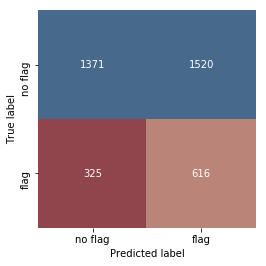

,Accuracy,Precision,Recall,F-Score,ROC-AUC:
0,0.518528,0.28839,0.654623,0.40039,0.564427


,Seed,Estimators,Max Leaf Nodes
0,580,190,18


,feature,importance
0,chain,0.133449
1,joy,0.084267
2,anticipation,0.066023
3,trust,0.058016
4,price_$,0.056109
5,negative,0.054327
6,positive,0.051324
7,cuisine_cafe/coffee/tea,0.044113
8,disgust,0.040226
9,sadness,0.040013


In [11]:
modinfo, res, featimp, cm, modscores, rfc = runRFC(x,y)
plotCM(cm, modscores)
showInfo(modinfo, featimp)
res =  pd.DataFrame(res)

# Run Model On Full Data

This data aggregates all past violation scores on record (including most recent ones) and predicts restaurants' next violation score.

In [ ]:
# new_x = pd.read_csv('new_violations.csv', dtype={'camis': int})
newbiz = pd.read_csv('new_biz.csv', dtype={'camis': int})

newres = runNewRFC(rfc, x2)
newres = pd.DataFrame(res)

print("Flag: {}".format(len(newres[newres.flag_pred == 1])))
print("No Flag: {}".format(len(newres[newres.flag_pred == 0])))

# Export Results for Website

In [0]:
#biz data
usecols = ['camis', 'dba','boro', 'zipcode', 'address',
           'cuisine', 'price', 'rating', 'lat', 'lon']

biz = pd.read_csv('biz.csv', usecols = usecols, dtype = {'camis': int})
data = res.merge(biz, how = 'left', on = 'camis')
data['flag_pred_proba'] = round(data.flag_pred_proba, 3)
data['geometry'] = list(zip(data.lon, data.lat))
data['geometry'] = data.geometry.apply(Point)
data['cuisine'] = data.cuisine.str.upper()

data = gpd.GeoDataFrame(data)


data.to_file('../Website/viomap.geojson', driver = 'GeoJSON')

# Analyze Results

In [0]:
usecols = ['camis', 'dba','boro', 'zipcode', 'address',
           'cuisine', 'price', 'rating', 'lat', 'lon']

biz = pd.read_csv('biz.csv', usecols = usecols, dtype = {'camis': int})
data = res.merge(biz, how = 'left', on = 'camis')
data['zipcode'] = data.zipcode.astype(str)

tp = data[(data.flag == 1) & (data.flag_pred == 1)]
fp = data[(data.flag == 0) & (data.flag_pred == 1)]
tn = data[(data.flag == 0) & (data.flag_pred == 0)]
fn = data[(data.flag == 1) & (data.flag_pred == 0)]

print("True Positive")
display(tp.head())
print("False Positive")
display(fp.head())
print("True Negative")
display(tn.head())
print("False Negative")
display(fn.head())

True Positive


,camis,flag,flag_pred,flag_pred_proba,dba,boro,zipcode,cuisine,address,price,rating,lat,lon
1,41219576,1,1,0.542715,EMPERADOR ELIAS RESTAURANT,BROOKLYN,11211,"latin (cuban, dominican, puerto rican, south &...",274 BROADWAY,$$,3.0,40.708630,-73.958880
5,41630839,1,1,0.505763,NOMAD,MANHATTAN,10001,american,1170 BROADWAY,$$$,4.5,40.744937,-73.988520
10,41246255,1,1,0.518850,ED'S LOBSTER BAR,MANHATTAN,10012,seafood,222 LAFAYETTE ST,$$$,4.0,40.722079,-73.997529
11,40399834,1,1,0.587272,HAN GAWI,MANHATTAN,10016,korean,12 EAST 32 ST,$$$,4.0,40.746737,-73.984662
13,40374192,1,1,0.528855,ELIO'S,MANHATTAN,10028,italian,1621 2ND AVE,$$$,3.5,40.776763,-73.952663


False Positive


,camis,flag,flag_pred,flag_pred_proba,dba,boro,zipcode,cuisine,address,price,rating,lat,lon
7,41611875,0,1,0.532019,VALHALLA,MANHATTAN,10019,american,815 9 AVE,$$,4.0,40.765960,-73.987370
9,50049489,0,1,0.538466,CENTRO ESPANOL,QUEENS,11103,spanish,4101 BROADWAY,$$,4.5,40.758710,-73.917850
12,50070585,0,1,0.552621,KING KABAB,QUEENS,11432,indian,16709 HILLSIDE AVE,$,3.5,40.709662,-73.796104
14,41424557,0,1,0.505918,BIG DADDY CARIBBEAN TASTE,BRONX,10470,caribbean,4406 WHITE PLAINS RD,$$,3.5,40.898650,-73.853910
18,50008122,0,1,0.506442,FOOD BO GARDEN RESTAURANT,BRONX,10459,chinese,934C E 163RD ST,$,3.0,40.820855,-73.896427


True Negative


,camis,flag,flag_pred,flag_pred_proba,dba,boro,zipcode,cuisine,address,price,rating,lat,lon
0,41480500,0,0,0.419022,BLACK GOLD,BROOKLYN,11231,cafe/coffee/tea,461 COURT ST,$$,4.5,40.677265,-73.998102
2,50043919,0,0,0.486691,CHENS GARDEN,BROOKLYN,11207,chinese,11046 FLATLANDS AVE,$,4.0,40.650063,-73.890901
3,41618312,0,0,0.473031,COUNTRY BOYZ JERK YARD RESTAURANT,BRONX,10469,caribbean,1182 EAST GUNHILL RD,$$,3.5,40.872890,-73.852820
6,50044862,0,0,0.423419,CHINA DELIGHT,QUEENS,11429,chinese,21882 HEMPSTEAD AVE,$,3.5,40.712948,-73.735558
15,40969350,0,0,0.346831,STARBUCKS,QUEENS,11375,cafe/coffee/tea,10102 QUEENS BLVD,$$,3.5,40.726288,-73.852754


False Negative


,camis,flag,flag_pred,flag_pred_proba,dba,boro,zipcode,cuisine,address,price,rating,lat,lon
4,50050304,1,0,0.460938,CHIKARASHI,MANHATTAN,10013,japanese,227 CANAL ST,$$,4.0,40.717870,-73.999480
8,40986939,1,0,0.495570,WASABI SUSHI,BROOKLYN,11214,japanese,2375 86 ST,$$,3.5,40.599650,-73.989490
23,50013579,1,0,0.499825,THAI BASIL,BROOKLYN,11229,thai,3682B NOSTRAND AVE,$$,3.0,40.594200,-73.940880
36,41371272,1,0,0.498060,LOCAL CAFE & COCKTAILS,MANHATTAN,10119,american,1 PENN PLAZA,$$,2.5,40.751630,-73.993615
60,40367789,1,0,0.454157,DANI PIZZA AND RESTAURANT,QUEENS,11415,pizza,8128 LEFFERTS BLVD,$,3.5,40.709002,-73.830498


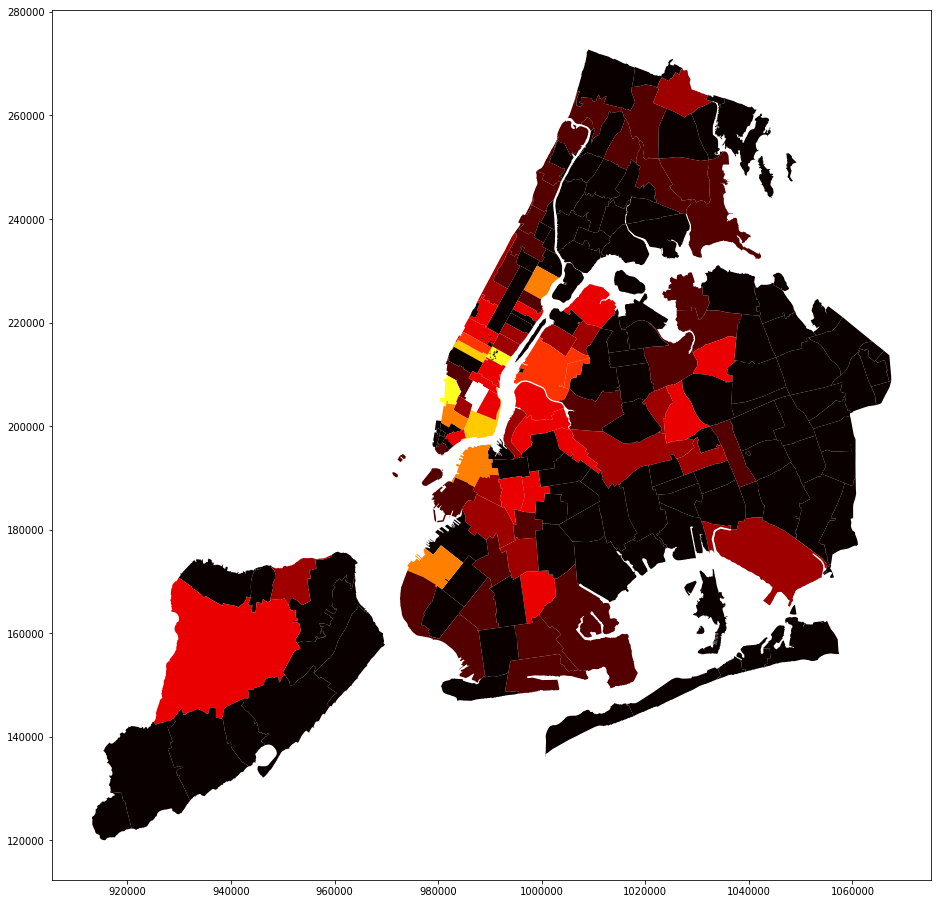

In [0]:
zips = gpd.read_file('ZIP_CODE_040114.shp')
zips.columns = zips.columns.str.lower()
fpcount = pd.DataFrame(fp.zipcode.value_counts().reset_index().rename(columns={'zipcode':'fpcount', 'index':'zipcode'}))
fncount = pd.DataFrame(fn.zipcode.value_counts().reset_index().rename(columns={'zipcode':'fncount', 'index':'zipcode'}))
fpmap = zips.merge(fpcount, how = 'left', on = 'zipcode')
fnmap = zips.merge(fncount, how = 'left', on = 'zipcode')
fig, ax = plt.subplots(figsize=(16,16))
# fpmap.plot(column='fpcount', cmap='hot', ax=ax)
fnmap.plot(column='fncount', cmap='hot', ax=ax)
plt.show()